## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set

num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP (15%)
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7540000081062317
epoch 2: valid acc = 0.8090000152587891
epoch 3: valid acc = 0.8289999961853027
epoch 4: valid acc = 0.8364999890327454
epoch 5: valid acc = 0.8525000214576721
epoch 6: valid acc = 0.8569999933242798
epoch 7: valid acc = 0.8579999804496765
epoch 8: valid acc = 0.8615000247955322
epoch 9: valid acc = 0.8650000095367432
epoch 10: valid acc = 0.8684999942779541
epoch 11: valid acc = 0.8675000071525574
epoch 12: valid acc = 0.8705000281333923
epoch 13: valid acc = 0.8709999918937683
epoch 14: valid acc = 0.8730000257492065
epoch 15: valid acc = 0.8725000023841858
test acc = 0.8605999946594238


Yufan's Note: Test accuracy for demo two-layer network is around 86%.

### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your 4-layer MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

In [4]:
# Create you MLP using TensorFlow functions.
hidden_dim = [200, 100, 50] # 3 hidden layers, dimensions provided by myself
reg_tf = tf.constant(1e-3) # regulation provided by myself

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.num_layers = len(hidden_dim) + 1
        self.W = [tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim[0]).astype('float32'))]
        self.b = [tf.Variable(np.zeros((hidden_dim[0],)).astype('float32'))]
        for i in range(1, self.num_layers - 1):
            self.W.append(tf.Variable(1e-2*np.random.rand(hidden_dim[i - 1], hidden_dim[i]).astype('float32')))
            self.b.append(tf.Variable(np.zeros((hidden_dim[i],)).astype('float32')))
        self.W.append(tf.Variable(1e-2*np.random.rand(hidden_dim[len(hidden_dim) - 1], 20).astype('float32')))
        self.b.append(tf.Variable(np.zeros((20,)).astype('float32')))    
        
    def call(self, inputs):
        """Run the model."""
        h = [tf.nn.relu(tf.matmul(inputs, self.W[0]) + self.b[0])] # input layer
        for i in range(1, self.num_layers - 1):
            h.append(tf.nn.relu(tf.matmul(h[len(h)-1], self.W[i]) + self.b[i]))
        out = tf.matmul(h[len(h)-1], self.W[len(self.W)-1]) + self.b[len(self.b)-1] # last layer no ReLU
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = 0
    for i in range(model.num_layers):
        L2_loss += tf.nn.l2_loss(model.W[i])
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# Calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    W_b = []
    for i in range(model.num_layers):
        W_b.append(model.W[i])
        W_b.append(model.b[i])
    return tape.gradient(loss_value, W_b)

# Calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 100 # provided by myself
num_batch = num_train//batch_size
num_epochs = 30 # provided by myself
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients
        W_b = []
        for i in range(model.num_layers):
            W_b.append(model.W[i])
            W_b.append(model.b[i])
        optimizer.apply_gradients(zip(grads, W_b))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.18549999594688416
epoch 2: valid acc = 0.1875
epoch 3: valid acc = 0.18950000405311584
epoch 4: valid acc = 0.19550000131130219
epoch 5: valid acc = 0.21199999749660492
epoch 6: valid acc = 0.3334999978542328
epoch 7: valid acc = 0.40149998664855957
epoch 8: valid acc = 0.3659999966621399
epoch 9: valid acc = 0.45249998569488525
epoch 10: valid acc = 0.5180000066757202
epoch 11: valid acc = 0.5559999942779541
epoch 12: valid acc = 0.6305000185966492
epoch 13: valid acc = 0.6859999895095825
epoch 14: valid acc = 0.7135000228881836
epoch 15: valid acc = 0.7379999756813049
epoch 16: valid acc = 0.7515000104904175
epoch 17: valid acc = 0.7615000009536743
epoch 18: valid acc = 0.7724999785423279
epoch 19: valid acc = 0.7900000214576721
epoch 20: valid acc = 0.7889999747276306
epoch 21: valid acc = 0.7990000247955322
epoch 22: valid acc = 0.8059999942779541
epoch 23: valid acc = 0.8144999742507935
epoch 24: valid acc = 0.8165000081062317
epoch 25: valid acc = 0.8155000

Yufan's Note: Test accuracy for this four-layer network is around 81.5%.

### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

In [5]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28)),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])
# model.summary() # DEBUG USE: visualize the model

# END of your code
#############################################################

#############################################################
# TODO: compile the model, set optimizer and loss

model.compile(
    optimizer=tf.keras.optimizers.SGD(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# END of your code
#############################################################

#############################################################
# TODO: train the model with our own dataset

model.fit(X_train, y_train, verbose=2, epochs=num_epochs, validation_data=(X_val,y_val)) # epochs is the same as the previous task (30)
# Test
test_results = model.evaluate(X_test, y_test, batch_size=batch_size) # batch size is the same as the previous task (100)
print("test acc =", test_results[1])

# END of your code
#############################################################

Epoch 1/30
1813/1813 - 3s - loss: 1.3025 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.6027 - val_sparse_categorical_accuracy: 0.7865
Epoch 2/30
1813/1813 - 3s - loss: 0.5149 - sparse_categorical_accuracy: 0.8190 - val_loss: 0.5156 - val_sparse_categorical_accuracy: 0.8025
Epoch 3/30
1813/1813 - 3s - loss: 0.4481 - sparse_categorical_accuracy: 0.8404 - val_loss: 0.5191 - val_sparse_categorical_accuracy: 0.8115
Epoch 4/30
1813/1813 - 3s - loss: 0.4090 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.4872 - val_sparse_categorical_accuracy: 0.8285
Epoch 5/30
1813/1813 - 3s - loss: 0.3812 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.4734 - val_sparse_categorical_accuracy: 0.8310
Epoch 6/30
1813/1813 - 3s - loss: 0.3606 - sparse_categorical_accuracy: 0.8684 - val_loss: 0.4638 - val_sparse_categorical_accuracy: 0.8370
Epoch 7/30
1813/1813 - 3s - loss: 0.3448 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.4448 - val_sparse_categorical_accuracy: 0.8445
Epoch 8/30
1813/1813

Yufan's Note: Test accuracy for this four-layer network (with keras) is around 86%.

## Part 2: t-SNE (5%)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [6]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [7]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set
num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [8]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=25.0)
print("it takes {} seconds".format(time.time()-tic))

2.804294456954031
The 100 th loop cost: 11.772869823169186, computation time: 1.9929299354553223
The 200 th loop cost: 0.5700437670438092, computation time: 3.9146528244018555
The 300 th loop cost: 0.5290841823287238, computation time: 5.838031053543091
The 400 th loop cost: 0.5211413510540003, computation time: 7.762868881225586
The 500 th loop cost: 0.519131937041702, computation time: 9.704535245895386
The 600 th loop cost: 0.5183470668003741, computation time: 11.63623595237732
The 700 th loop cost: 0.5179677564927158, computation time: 13.589478492736816
The 800 th loop cost: 0.5177645535402768, computation time: 15.518038272857666
The 900 th loop cost: 0.5176463093813666, computation time: 17.455402135849
The 1000 th loop cost: 0.5175738127929266, computation time: 19.372344970703125
it takes 20.061599731445312 seconds


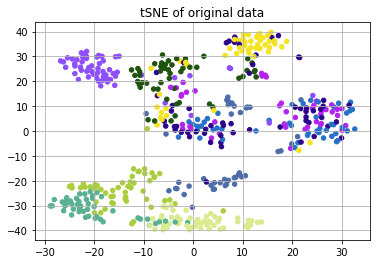

In [9]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.title("tSNE of original data")
plt.grid()
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [10]:
# Define MLP model (Task 2)
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 290
epoch 1: valid acc = 0.786, new learning rate = 0.00095
epoch 2: valid acc = 0.823, new learning rate = 0.0009025
epoch 3: valid acc = 0.842, new learning rate = 0.000857375
epoch 4: valid acc = 0.844, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.854, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.848, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.8545, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.8615, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.868, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.8615, new learning rate = 0.0005987369392383785
test acc: 0.8515


0.8515

Yufan's Note: Test accuracy for this two-layer MLP model is around 85%.

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [11]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then   #
# apply softmax to obtain output of the MLP model.                          #
#############################################################################

from utils.classifiers.softmax import softmax

# Pass data through dense and affine layers
out = model.forward(X)
# Apply softmax
out = softmax(out)
# tSNE
Y = tsne(out, low_dim=2, perplexity=25.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.09774138001574915
The 100 th loop cost: 8.595497121110315, computation time: 1.966965913772583
The 200 th loop cost: 0.20610334014327059, computation time: 3.924370288848877
The 300 th loop cost: 0.16476252635655858, computation time: 5.895366907119751
The 400 th loop cost: 0.15124566449840687, computation time: 7.900393009185791
The 500 th loop cost: 0.1460788229151842, computation time: 9.906155109405518
The 600 th loop cost: 0.14317697856043596, computation time: 11.943224430084229
The 700 th loop cost: 0.1412534452828718, computation time: 13.923303842544556
The 800 th loop cost: 0.1398472485596136, computation time: 15.895534753799438
The 900 th loop cost: 0.13874854556215796, computation time: 17.821622610092163
The 1000 th loop cost: 0.1378371223497574, computation time: 19.784768104553223
it takes 20.606956958770752 seconds


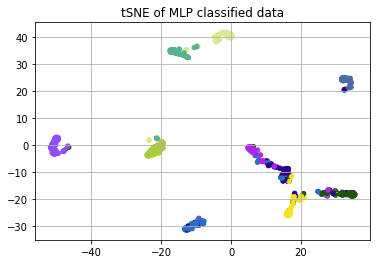

In [12]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data                             #
#############################################################################

plt.scatter(Y[:,0], Y[:,1], 20, color_labels) # color_labels has been created
plt.title("tSNE of MLP classified data")
plt.grid()
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

Yufan's Note: Compare with the original data, the output from the two-layer MLP is classified into different groups. However, the visualization looks too scattered, so we need to tune the parameter in the next cell.

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [13]:
# Tune the parameter, show the results.
# run tSNE
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

# No need to re calculate MLP output (out) here

# tSNE (different parameter)
Y = tsne(out, low_dim=2, perplexity=15.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.06831527068501052
The 100 th loop cost: 9.785043862798005, computation time: 1.9369549751281738
The 200 th loop cost: 0.2906036683045318, computation time: 3.8916213512420654
The 300 th loop cost: 0.21361837786003424, computation time: 5.807986736297607
The 400 th loop cost: 0.18711003571008727, computation time: 7.747655391693115
The 500 th loop cost: 0.17676686978094178, computation time: 9.653888940811157
The 600 th loop cost: 0.17088904155329024, computation time: 11.587926387786865
The 700 th loop cost: 0.1670190794295132, computation time: 13.538184404373169
The 800 th loop cost: 0.1642383657664784, computation time: 15.499106407165527
The 900 th loop cost: 0.16213865467504565, computation time: 17.480719804763794
The 1000 th loop cost: 0.16048427750644384, computation time: 19.447355270385742
it takes 20.35160803794861 seconds


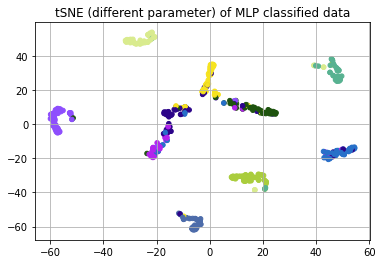

In [14]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

plt.scatter(Y[:,0], Y[:,1], 20, color_labels) # color_labels has been created
plt.title("tSNE (different parameter) of MLP classified data")
plt.grid()
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

Yufan's Note: The visualization looks better now.